# Processing Next-generation Sequencing Datasets Using Python
based on the same-named article by Tiago Antao<br>
see: https://hub.packtpub.com/processing-next-generation-sequencing-datasets-using-python/

## VCF files

Text file format for storing long genome information. However, the format stores just the variants.
### Structure

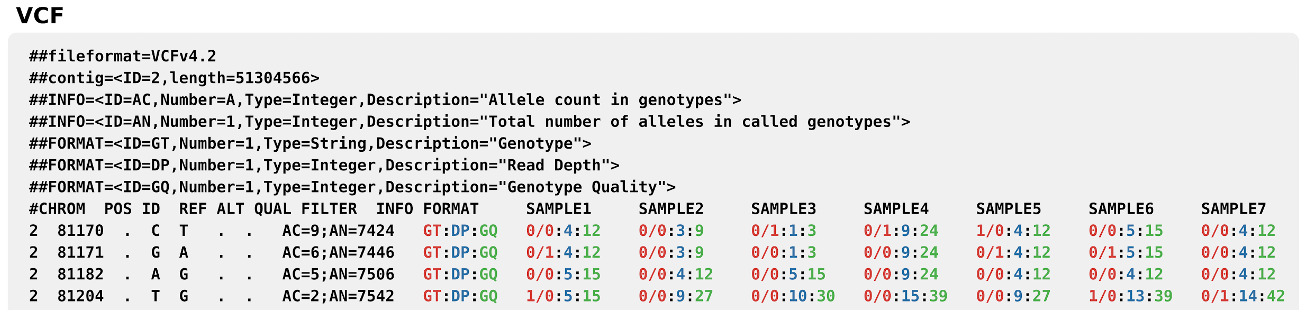

source: https://en.wikipedia.org/wiki/Variant_Call_Format#/media/File:Binary_BCF_versus_VCF_format.png
### Meta-information

### Header
The Header consists of several columns: 8 specified and following optional. The specified are variant level information <br>
CHROM - The name of the chromosome the variant is on <br>
POS - The position of the variant <br>
ID - The name of the variant <br>
REF - The reference allele of the variant <br>
ALT - The mutant or alternate allele <br>
QUAL - The quality of the variant <br>
FILTER - Information about the passing or not passing through the applied filter by the variant <br>
INFO - Summary of the information about the variant <br>
<br>
The remaining columns contain the sample data information for which the format and type is specified by the 9th column "FORMAT"

### Variants
Every variant is described by one row, called record. The data of every column of the variant row gives information according to the 8 specified attributes, the format and the data of each sample on the variant. Iterating through the variants gives the records ordered:<br>
>Record(CHROM=3L, POS=264, REF=C, ALT=[T])<br>
Record(CHROM=3L, POS=357, REF=G, ALT=[A])<br>
Record(CHROM=3L, POS=361, REF=A, ALT=[T])...<br>

### Sample Information
In every record and therefore at every position on the reference genome where a variant is found, every information about every sample is displayed. Hence, there are two levels of information, the variant level and the sample level. Iterating through the samples gives you sample information for one variant:<br>
>Call(sample=AC0090-C, CallData(GT=./., AD=None, DP=None, GQ=None, MQ0=None, PL=None))<br>
Call(sample=AC0091-C, CallData(GT=0/0, AD=[8, 3], DP=11, GQ=3, MQ0=10, PL=[0, 3, 39]))<br>
Call(sample=AC0092-C, CallData(GT=0/0, AD=[10, 13], DP=22, GQ=6, MQ0=21, PL=[0, 6, 76]))...<br>

__GT - Genotype__. For every sample it is displayed, how the genotype corresponding to the reference base is. For example a diploid chromosom with a T and a G at the specific position where the reference position is also a T would be annotated with a genotype of "0/1". 0 would stand for the homozygous allele (hence the T) and 1 for the heterozygous allele (hence the G).<br>
__DP - Read Depth__ (or also coverage). This attribute shows the sample specific read depth and therefore, how much the reads per sample are supporting the genotype information. Generally a higher read depth is preferable.

### Data source
Data for explaining and analysing the VCF Format is obtained from<br>
- 1000 Genomes Project: International cooperation to sequence the genomes of several thousands of human genomes with high coverage http://www.1000genomes.org/<br>
- Ag1000G Project: International cooperation to sequence the genomes of several thousands of anopheles genomes with high coverage http://www.malariagen.net/projects/vector/ag1000g<br>

### Data download
#### Human Genome
For this workthrough, a manual download approach from the terminal was chosen. An example is shown below.<br>
```bash
wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/supporting/vcf_with_sample_level_annotation/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5_extra_anno.20130502.genotypes.vcf.gz (download manually)
wget ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/supporting/vcf_with_sample_level_annotation/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5_extra_anno.20130502.genotypes.vcf.gz.tbi (very important to also download the tbi file)
tabix -fh ALL.chr22.phase3_shapeit2_mvncall_integrated_v5_extra_anno.20130502.genotypes.vcf.gz 22:1-17000000 |bgzip -c > genotypes.vcf.gz
tabix -p vcf genotypes.vcf.gz
```
#### Anopheles Genome
```bash
wget ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:1-200000 |bgzip -c > centro.vcf.gz | tabix -fh
wget ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:21000001-21200000 |bgzip -c > standard.vcf.gz | tabix -fh
tabix -p vcf centro.vcf.gz
tabix -p vcf standard.vcf.gz
```
#### Conda Environment
All packages and dependencies used for processing following code can be found in a markdown-cell in the github repository. To use it, a conda environment has to be created based on the text in this cell saved in a yml file.

### Packages

In [1]:
from collections import defaultdict
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import numpy as np
import vcf

### Standard Information

With a simple loop through the methods info and format, some important information can be shown with corresponding descriptions. Also, specific metadata can be accessed.

In [2]:
file = "data/genotypes.vcf.gz"
v = vcf.Reader(filename=file)
print('Variant Level information')
for info in v.infos:
    print ("{} | {}".format(info,v.infos[info].desc))

Variant Level information
CIEND | Confidence interval around END for imprecise variants
CIPOS | Confidence interval around POS for imprecise variants
CS | Source call set.
END | End coordinate of this variant
IMPRECISE | Imprecise structural variation
MC | Merged calls.
MEINFO | Mobile element info of the form NAME,START,END<POLARITY; If there is only 5' OR 3' support for this call, will be NULL NULL for START and END
MEND | Mitochondrial end coordinate of inserted sequence
MLEN | Estimated length of mitochondrial insert
MSTART | Mitochondrial start coordinate of inserted sequence
SVLEN | Difference in length between REF and ALT alleles
SVTYPE | Type of structural variant
TSD | Precise Target Site Duplication for bases, if unknown, value will be NULL
AC | Total number of alternate alleles in called genotypes
AF | Estimated allele frequency in the range (0,1]
NS | Number of samples with data
AN | Total number of alleles in called genotypes
ASN_AF | Allele frequency in the ASN population

In [3]:
print('Sample Level information')
for fmt in v.formats:
    print ("{} | {}".format(fmt,v.formats[fmt].desc))

Sample Level information
GT | Genotype
DP | Per sample read depth


In [4]:
print('Metadata information')
print("{} | {}".format("FileDate",v.metadata["fileDate"]))
print("{} | {}".format("Referenz",v.metadata["reference"]))

Metadata information
FileDate | 20140730
Referenz | ftp://ftp.1000genomes.ebi.ac.uk//vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz


### Anopheles data

In this recipe, we will not use data from the Human 1000 genomes project; we want “dirty” unfiltered data that has a lot of common annotations that can be used to filter it. We will use data from the Anopheles 1000 genomes project (Anopheles is the mosquito vector involved in the transmission of the parasite causing malaria), which makes available filtered and unfiltered data.
We will get a part of the centromere of chromosome 3L for around 100 mosquitoes, followed by a part somewhere in the middle of that chromosome (citation from T.Antao).

In [5]:
names = ["data/centro.vcf.gz", "data/standard.vcf.gz"]

for name in names:
    recs = vcf.Reader(filename=name)
    print("Name | {}".format((name)))
    print("Format |",[x for x in recs.formats])
    print("{} | {}".format("Reference",recs.metadata["reference"]),"\n")

Name | data/centro.vcf.gz
Format | ['AB', 'AD', 'DP', 'GQ', 'GT', 'MQ0', 'PL']
Reference | file:///data/anopheles/ag1000g/data/genome/AgamP3/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa 

Name | data/standard.vcf.gz
Format | ['AB', 'AD', 'DP', 'GQ', 'GT', 'MQ0', 'PL']
Reference | file:///data/anopheles/ag1000g/data/genome/AgamP3/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa 



### Samples

By "samples" physically present sequences are meant which have been studied in an experiment. The sample names are mostly related to the input and are given in a short code of letters and numbers. Here, all sample names are shown, which relate to the downloaded vcf file. Since, both sequence segments are from the same chromosome, the number of samples are the same for both.

In [6]:
v2=vcf.Reader(filename=names[0])
v3=vcf.Reader(filename=names[1])
print("samples:",v2.samples,"\n")
print("quantity v2:",len(v2.samples))
print("quantity v3:",len(v3.samples))

samples: ['AC0090-C', 'AC0091-C', 'AC0092-C', 'AC0093-C', 'AC0094-C', 'AC0095-C', 'AC0096-C', 'AC0097-C', 'AC0098-C', 'AC0099-C', 'AC0100-C', 'AC0101-C', 'AC0102-C', 'AC0103-C', 'AC0104-C', 'AC0106-C', 'AC0107-C', 'AC0108-C', 'AC0109-C', 'AC0110-C', 'AC0111-C', 'AC0112-C', 'AC0113-C', 'AC0114-C', 'AC0115-C', 'AC0116-C', 'AC0117-C', 'AC0118-C', 'AC0119-C', 'AC0120-C', 'AC0121-C', 'AC0122-C', 'AC0123-C', 'AC0124-C', 'AC0125-C', 'AC0126-C', 'AC0127-C', 'AC0128-C', 'AC0129-C', 'AC0130-C', 'AC0131-C', 'AC0132-C', 'AC0133-C', 'AC0135-C', 'AC0136-C', 'AC0137-C', 'AC0138-C', 'AC0139-C', 'AC0140-C', 'AC0142-C', 'AC0143-C', 'AC0144-C', 'AC0145-C', 'AC0147-C', 'AC0148-C', 'AC0149-C', 'AC0150-C', 'AC0151-C', 'AC0152-C', 'AC0153-C', 'AC0154-C', 'AC0156-C', 'AC0158-C', 'AC0159-C', 'AC0160-C', 'AC0161-C', 'AC0162-C', 'AC0163-C', 'AC0164-C', 'AC0166-C', 'AC0167-C', 'AC0168-C', 'AC0169-C', 'AC0170-C', 'AC0171-C', 'AC0172-C', 'AC0173-C', 'AC0174-C', 'AC0176-C', 'AC0178-C', 'AC0179-C', 'AC0180-C', 'AC018

### Calling data from variants

The next() command gives access to the first variant information record. The first 4 specified attributes are displayed when printing the variable rec. The next 4 specified attributes and the format can be accessed individually.

In [7]:
for name in names:
    recs = vcf.Reader(filename=name)
    rec = next(recs)
    print(name)
    print(rec, "QUAL={}, FILTER={}".format(rec.QUAL,rec.FILTER,))
    print("Additional Variant level information:", rec.INFO)
    print("Sample format:", rec.FORMAT, "\n")

data/centro.vcf.gz
Record(CHROM=3L, POS=264, REF=C, ALT=[T]) QUAL=124.55, FILTER=['LowDP', 'RepeatMask']
Additional Variant level information: {'ABHet': 0.469, 'ABHom': 0.642, 'AC': [4], 'AF': [0.047], 'AN': 86, 'BaseCounts': [12, 12595, 6, 8703], 'BaseQRankSum': 1.236, 'DP': 1168, 'Dels': 0.0, 'EFF': ['INTERGENIC(MODIFIER||||||||||1)'], 'FS': 0.0, 'GC': 44.89, 'HRun': 2, 'HW': 103.6, 'HaplotypeScore': 0.073, 'InbreedingCoeff': -0.0988, 'MQ': 4.47, 'MQ0': 20805, 'MQRankSum': 1.39, 'NDA': 1, 'OND': 0.362, 'QD': 0.51, 'ReadPosRankSum': -0.618, 'VariantType': 'SNP'}
Sample format: GT:AD:DP:GQ:MQ0:PL 

data/standard.vcf.gz
Record(CHROM=3L, POS=21000002, REF=C, ALT=[G]) QUAL=5247.61, FILTER=['LowDP', 'Multiallelic', 'RepeatMask']
Additional Variant level information: {'AC': [19], 'AF': [0.092], 'AN': 206, 'BaseCounts': [6, 11957, 519, 91], 'BaseQRankSum': -0.951, 'DP': 1487, 'Dels': 0.02, 'EFF': ['INTERGENIC(MODIFIER||||||||||1)', 'INTERGENIC(MODIFIER||||||||||2)'], 'FS': 25.03, 'GC': 43.14

With iterating through all records, the total amount of variants can be accessed through storing every position of every record in a list and then print out the length of the list.

In [8]:
for name in names:
    my_pos=[]
    recs = vcf.Reader(filename=name)
    for rec in recs:
        my_pos.append(rec.POS)
    print("length of {}: {}".format(name,len(my_pos)))

length of data/centro.vcf.gz: 10319
length of data/standard.vcf.gz: 49294


### Calling data from sample

GT stands for Genotype information. For example a genotype of 0/0 would mean, that specific sample genotype is homozygot accordant to the reference base. <br>
With the genotype function, some information about single samples can be accessed. It is shown, that additionally every genotype variation for every sample can be accessed. Also, it is shown here, that the annotation AC is the sum of all heterozygous sample calls in a variant

In [9]:
v3 = vcf.Reader(filename=names[1])
rec = next(v3)
print(names[1],"- AC:",rec.INFO["AC"],"\n")
GTlist = []
totalHetGT = 0
for smp in rec:
    GTlist.append(smp['GT'])
    if smp.is_het:
        totalHetGT += 1
print(GTlist,"\n")
print("Sum of Heterzygous Genotypes (= AC):", totalHetGT)

data/standard.vcf.gz - AC: [19] 

['0/0', '0/1', '0/1', '0/0', '0/0', '0/0', '0/0', '0/1', '0/0', '0/0', '0/1', '0/0', '0/1', '0/0', '0/1', '0/1', '0/0', '0/0', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1', '0/0', '0/1', '0/0', '0/0', '0/1', '0/0', '0/1', '0/0', '0/1', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1'] 

Sum of Heterzygous Genotypes (= AC): 19


#### Important abbreviations
__GT__: Genotype - As shown before, shows how the variant is related to the reference allele <br>
__AC__: Total number of alternate alleles in called genotypes <br>
__DP__: Approximate read depth (for variant or for sample level present) <br>
__GQ__: The Genotype Quality represents the Phred-scaled confidence that the genotype assignment (GT) is correct, derived from the genotype PLs <br>
__MQ__: Mapping Quality - indication of how unique the regions sequence is (the higher MQ, the more unique). -10 * log( P(mapping position is wrong)) <br>
__MQ0__: Count of all reads with MAPQ = 0 across all samples, used for quality contol, high counts typically indicate regions where it is difficult to make confident calls<br>
__PL__: "Normalized" Phred-scaled likelihoods of the possible genotypes. For the typical case of a monomorphic site (where there is only one ALT allele) in a diploid organism, the PL field will contain three numbers, corresponding to the three possible genotypes (0/0, 0/1, and 1/1). 

### Variant Overview

The defaultdic function can be used to count values for a given key. Here, the records are traversed through while the combination of the variant type and subtype is given as key and every SNP is counted which fills that specific condition.
The dictionary num_alts is used to count all SNP with various Alternative Alleles. Therefore, all SNP with one ALT are counted, then those with two and then those whith three.

In [10]:
for name in names: 
    recs = vcf.Reader(filename=name)
    my_type = defaultdict(int)
    num_alts = defaultdict(int)
    print(name)
    for rec in recs:
        my_type[rec.var_type, rec.var_subtype] += 1
        if rec.is_snp:
            num_alts[len(rec.ALT)] += 1
    print("my_type:", [(key,val) for key,val in my_type.items()])
    print("num_alts:",[(key,val) for key,val in num_alts.items()],"\n")

data/centro.vcf.gz
my_type: [(('snp', 'ts'), 4957), (('snp', 'tv'), 4729), (('snp', 'unknown'), 633)]
num_alts: [(1, 9686), (3, 56), (2, 577)] 

data/standard.vcf.gz
my_type: [(('snp', 'tv'), 19775), (('snp', 'unknown'), 5731), (('snp', 'ts'), 23788)]
num_alts: [(1, 43563), (3, 292), (2, 5439)] 



#### Abbreviations
variant type: (snp = single nucleotide polymorphism)<br>
subtype: (ts/tv = transition(Pur to Pur)/transversion(Pur to Pyr or Pyr to Pur))

Text(0.5, 0.98, 'Alternate Allele count per Variant')

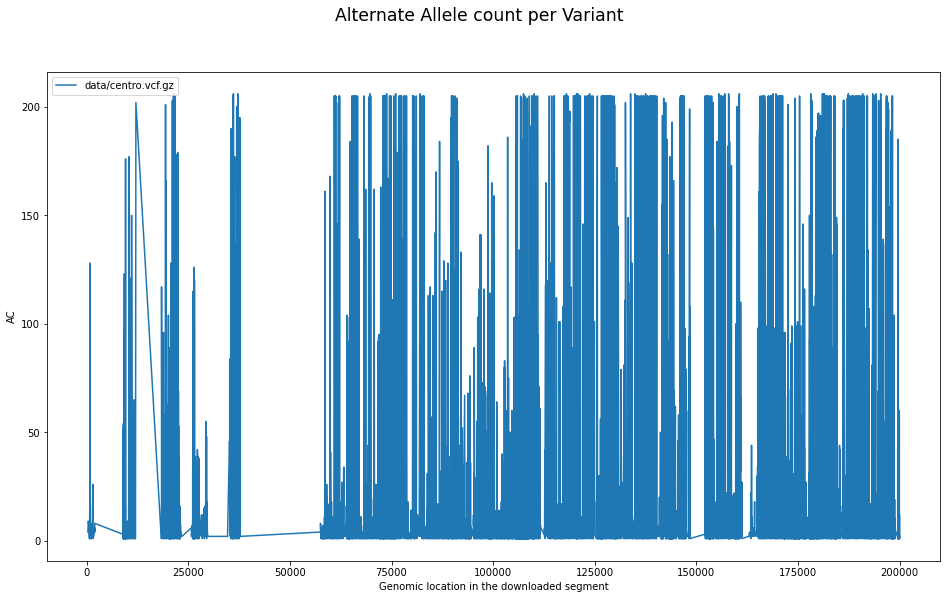

In [11]:
v2 = vcf.Reader(filename=names[0])
len_v2=[]
for rec in v2:
    if not rec.is_snp or len(rec.ALT) > 1:
        continue
    len_v2.append((rec.POS,rec.INFO['AC']))

x_pos = []
y_ac = []
fig, ax = plt.subplots(figsize=(16, 9))
for pos, ac in len_v2:
    x_pos.append(pos),y_ac.append(ac)
ax.plot(x_pos,y_ac, label=names[0])
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('AC')
fig.suptitle('Alternate Allele count per Variant', fontsize='xx-large')

Text(0.5, 0.98, 'Alternate Allele count per Variant')

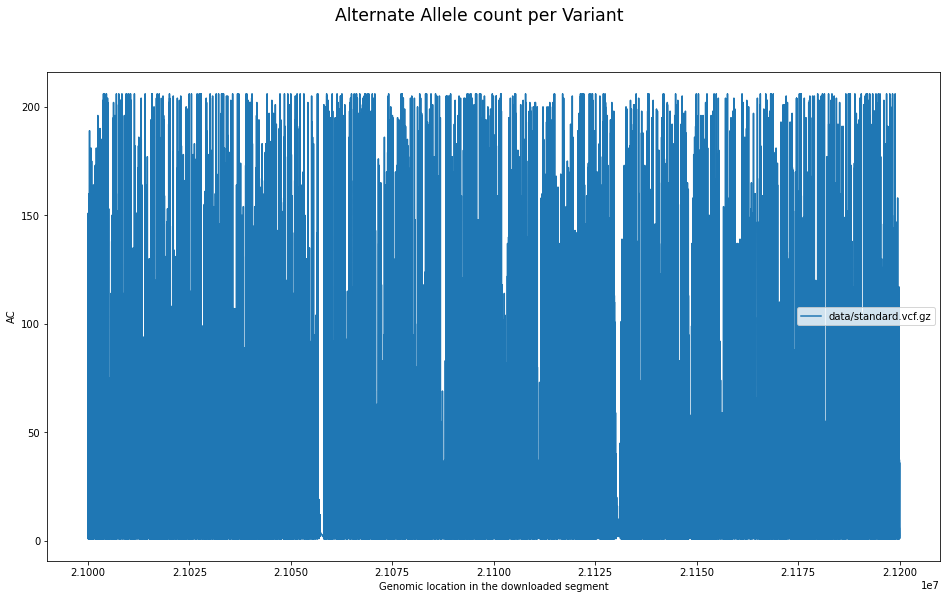

In [12]:
v3 = vcf.Reader(filename=names[1])
len_v3=[]
for rec in v3:
    if not rec.is_snp or len(rec.ALT) > 1:
        continue
    len_v3.append((rec.POS,rec.INFO['AC']))

x_pos = []
y_ac = []
fig, ax = plt.subplots(figsize=(16, 9))
for pos, ac in len_v3:
    x_pos.append(pos),y_ac.append(ac)
ax.plot(x_pos,y_ac, label=names[1])
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('AC')
fig.suptitle('Alternate Allele count per Variant', fontsize='xx-large')

### Functions do_window and apply_win_funs

#### do_window
The function do_window is called with the variables recs, size and fun. In recs the records of the respective variants in the vcf file are stored. 
The variable "size" is an integer that describes the size of the windows. The vcf files both contain 200.000 bp and are divided by a size of 2000 into 1000 windows of 2000 bp each.
With fun, a specifiable function is passed, which is used on every record. Thus, the function can be reused modularly.
In this case a Lambda function is called which generates a single 1 for an input (Hence, a variant).

With the For loop "rec in recs" the respective records of the vcf file are iterated through. Here, every variant which is not a SNP or has more than 1 alternative allele, is discarded. Therefore, just SNPs with one ALTs are considered.
The position of the first variant in the file is stored in the variable start. This is used for the calculation of the respective window. The variable my_win is related to the number of the respective window by subtracting the fixed start position from the record position and then by dividing the window size with a rounding to the nearest integer. To this, 1 is added in each case, so that the first window does not get the designation 0.

Example calculation: the first variant in the vcf file centro.vcf has the position 264. This position is stored in start at the first iteration and my_win gets the value 1 + (264 - 264) // 2000 = 1. Up to position 2263 my_win would be calculated with 1 by rounding down 1 + (2263 - 264) // 2000 = 1. From the next position on my_win would be calculated to 2.

With a while loop, whenever the length of the initially empty list is smaller than the designation of the current window, an empty list is added as a list element. Therefore, for every window one empty list is appended.
With the last line in the for loop, when the function lambda x is passed: [1], a 1 is entered into the respective inner list for each SNP with only one alternative base.

Consequently, an empty list is created for each window and for each single-allele SNP in the respective area, a 1 is passed into the list as a value. Given, in the sequence covered by the first window, five variants would be found and in the second window, zero, the beginning of the final list would look like this: [[1, 1, 1, 1, 1],[],...

In [13]:
def do_window(recs, size, fun):
    start = None
    win_res = []
    for rec in recs:
        if not rec.is_snp or len(rec.ALT) > 1:
            continue
        if start is None:
            start = rec.POS
        my_win = 1 + (rec.POS - start) // size
        while len(win_res) < my_win:
            win_res.append([])
        win_res[my_win - 1].extend(fun(rec))
    return win_res

#### apply_win_funs
This function is called with the results from the do_window function, hence a list with a list in it for each window, filled with a 1 for every variant. Additionally, a dictionary "funs" is passed, which contains the name and the respective function to be applied on the windows. For the first time, this funcion is called, the dictionary {'sum':sum} is passed. This function is meant to add all the entries of each inner list together.

The loop "for win in wins" is used to iterate through the inner lists of the do_window result. In the process, a dictionary my_funs is initialized for each window. The "funs" dictionary is iterated through and the respective name (here: 'sum') with the applied function (here: sum) is passed to the respective window. The result is stored as the only entry in my_funs.

Since the "funs" dictionary is iterated through with the name as key and the function as value, it is possible to apply multiple functions.

For example, my_funs for the first five entries would look like this: "{'sum': 41}, {'sum': 0}, {'sum': 0}, {'sum': 0}, {'sum': 208},...". 

These dictionaries are appended to the fun_results list and then returned.

In [14]:
def apply_win_funs(wins, funs):
    fun_results = []
    for win in wins:
        my_funs = {}
        for name, fun in funs.items():       
            try:
                my_funs[name] = fun(win)
            except:
                my_funs[name] = None
        fun_results.append(my_funs)    
    return fun_results

### Applying the functions

#### Creating the main-dictionaries
In this code block an empty dictionary wins is initialized and the window size is defined. The namelist of the partially downloaded chromosomes are then iterated through and each corresponding file is stored in the variable recs after being parsed by the vcf reader.
The variable "recs" is passed as value of the function do_window and the result from the function is stored in the empty dictionary wins.
Here the key is the name of the vcf file and the value is the result from the do_window function. Those values are lists with one inner lists per window each filled with "1" per SNP. The length of the final dictionaries relate to the windows size: 200,000 bp per file / 2000 window size = 100 windows

In [15]:
wins = {}
size = 2000
for name in names:
    recs = vcf.Reader(filename=name)
    wins[name] = do_window(recs, size, lambda x: [1])
    print(name,len(wins[name]))

data/centro.vcf.gz 100
data/standard.vcf.gz 100


#### Processing the gathered data

A new empty dictionary "stat" is initialized and an empty plot is generated. The dictionary wins are iterated through, working with two run variables each representing the key (the name of the file) and the value (the individual bi-allelic SNPs per window).<br>
The empty dictionary "stat" is filled with the vcf file name as key and the result of the function apply_win_funs on the wins dictionary values. 
Thereby, a dict {'sum': sum} is passed as second value which determines the function that should be performed.
In the same for loop the x-axis of the plot is defined with the numbers 0-100 (total length of the two dicts stat) times the size 2000.
These numbers [0,2000,4000,6000...] are generated per wins dict and stored as x-axis in the plot.
Then, the calculated results from apply_window are transfered in the plot.
Afterwards the plot is modified by adding a legend, a heading and axis labels.

Text(0.5, 0.98, 'Number of bi-allelic SNPs along the genome')

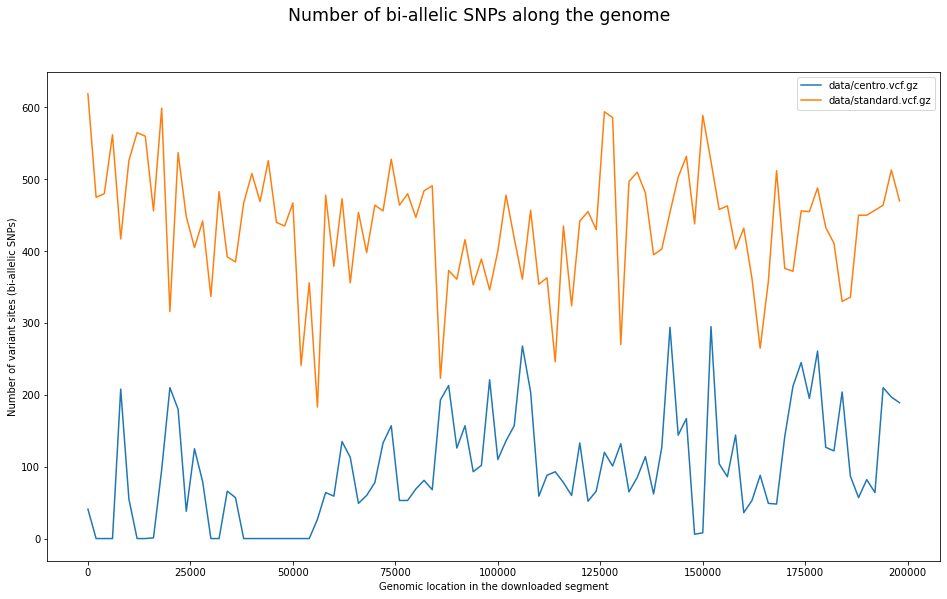

In [16]:
stats = {}
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in wins.items():
    stats[name] = apply_win_funs(nwins, {'sum': sum})
    x_lim = [i * size  for i in range(len(stats[name]))]
    ax.plot(x_lim, [x['sum'] for x in stats[name]], label=name)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('Number of variant sites (bi-allelic SNPs)')
fig.suptitle('Number of bi-allelic SNPs along the genome', fontsize='xx-large')

### Function get_sample

The get_sample function is called with a single record of the vcf reader, the annotation of interest, and a specific data type.
First, an empty list is created and the samples information from the record is written to a variable. Therefore, this function takes a variant and retreives the sample information from that. Here, the first four samples (rec.samples) look like this when printed:

>Call(sample=AC0090-C, CallData(GT=./., AD=None, DP=None, GQ=None, MQ0=None, PL=None))<br>
Call(sample=AC0091-C, CallData(GT=0/0, AD=[8, 3], DP=11, GQ=3, MQ0=10, PL=[0, 3, 39]))<br>
Call(sample=AC0092-C, CallData(GT=0/0, AD=[10, 13], DP=22, GQ=6, MQ0=21, PL=[0, 6, 76]))<br>
Call(sample=AC0093-C, CallData(GT=0/0, AD=[23, 12], DP=34, GQ=3, MQ0=34, PL=[0, 3, 30])) 

The samples for each variant are iterated through with a for loop and the selected annotation (here: MQ0) is explicitly converted to the previously selected data type (here: int) in each case and written to the empty list. This list is then passed back with all annotations found. The names of the files are inserted as keys into the final dict mq0_wins.

The get_samples function is called from the do_window function. The latter is called with the arguments recs (the genome data), size (=5000) and a partial function call of get_sample. With that, all to the chosen annotation corresponding values are stored in one list per window.
Because of the do_window function only those positions with a SNP are considered.

Since each window contains 5000 positions and each position contains 103 samples, the maximum number of MQ0 values per window is 515,000.
Since not every position has a MQ0 value, the first list entry in win_res has a length of 3,457. The second list entry contains 19,705 values etc. 
```python
print("len",len(mq0_wins[centro.vcf.gz][0])) -> len 3457
print("entry",mq0_wins[centro.vcf.gz][0]) -> entry [10, 21, 34, 28, 33, 23, 33, 38, 23, 27, ...
```
The two mq0_win dicts have 40 entries each (200,000 / 5,000 = 40)

In [17]:
def get_sample(rec, annot, my_type):
    #We will ignore Nones
    res = []
    samples = rec.samples
    for sample in samples:
        if sample[annot] is None:
            continue
        res.append(my_type(sample[annot]))
    return res

#### Applying get_sample

The dict mq0_wins is passed and an empty dict is filled with the data generated by the function call apply_win_funs. Two numpy functions are passed in a dict: median and percentile. These functions are applied to each window and the result is stored in a new dict with the name of the function as key and the result of the function from the respective window as value.

The result of apply_win_funs is stored in stats with the file path to the vcf file as key and looks like this:

>centro.vcf.gz [{'median': 25.0, '95': 50.0}, {'median': 0.0, '95': 4.0}, {'median': 1.0, '95': 19.0}, {'median': 3.0, '95': 50.0}, {'median': 8.0, '95': 52.0}, {'median': 10.0, '95': 26.0}, {'median': 22.0, '95': 42.0}, {'median': 8.0, '95': 32.0}, {'median': nan, '95': None}, {'median': nan, '95': None}, {'median': nan, '95': None}, {'median': 1.0, '95': 27.0}, {'median': 1.0, '95': 12.0}, {'median': 0.0, '95': 4.0}, {'median': 0.0, '95': 8.0}, {'median': 0.0, '95': 10.0}, {'median': 0.0, '95': 62.0}, {'median': 4.0, '95': 27.0}, {'median': 1.0, '95': 12.0}, {'median': 0.0, '95': 13.0}, {'median': 1.0, '95': 32.0}, {'median': 0.0, '95': 19.0}, {'median': 8.0, '95': 51.0}, {'median': 0.0, '95': 7.0}, {'median': 0.0, '95': 1.0}, {'median': 1.0, '95': 10.0}, {'median': 1.0, '95': 7.0}, {'median': 0.0, '95': 2.0}, {'median': 8.0, '95': 59.0}, {'median': 1.0, '95': 28.0}, {'median': 1.0, '95': 7.0}, {'median': 1.0, '95': 25.0}, {'median': 3.0, '95': 25.0}, {'median': 0.0, '95': 38.0}, {'median': 1.0, '95': 38.0}, {'median': 10.0, '95': 39.0}, {'median': 0.0, '95': 15.0}, {'median': 0.0, '95': 4.0}, {'median': 0.0, '95': 2.0}, {'median': 2.0, '95': 22.0}]

The dict again has a length of 40, one entry per window (200,000 bp / 5,000 window size = 40 windows).

This data is transfered into an x-axis list to be plotted. The plot is modified by adding a legend, a heading and axis labels. Sometimes, a python error is shown when running. This error seems to relate to the determination of the y-axis limit.

/Users/adriandoerr/mambaforge/envs/ngspy/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/adriandoerr/mambaforge/envs/ngspy/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Distribution of MQ0 along the genome, MQ0: Total Mapping Quality Zero Reads')

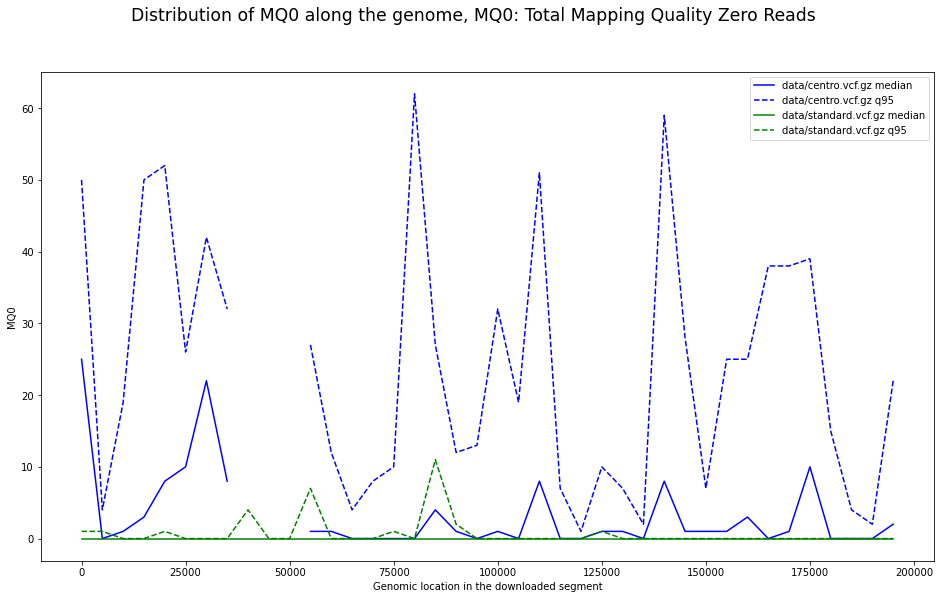

In [18]:
mq0_wins = {}
size = 5000
for name in names:
    recs = vcf.Reader(filename=name)
    mq0_wins[name] = do_window(recs, size, functools.partial(get_sample, annot='MQ0', my_type=int))

stats = {}
colors = ['b', 'g']
i = 0
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in mq0_wins.items():
    stats[name] = apply_win_funs(nwins, {'median': np.median, '95': functools.partial(np.percentile, q=95)})
    x_lim = [j * size  for j in range(len(stats[name]))]
    ax.plot(x_lim, [x['median'] for x in stats[name]], label=name+" median", color=colors[i])
    ax.plot(x_lim, [x['95'] for x in stats[name]], '--', label=name+" q95", color=colors[i])
    i += 1
#ax.set_ylim(0, 60)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('MQ0')
fig.suptitle('Distribution of MQ0 along the genome, MQ0: Total Mapping Quality Zero Reads', fontsize='xx-large')

Here, the same functions are used only with a different annotation 'DP' (=read depth)

Text(0.5, 0.98, 'Distribution of DP along the genome, DP: Approximate read depth')

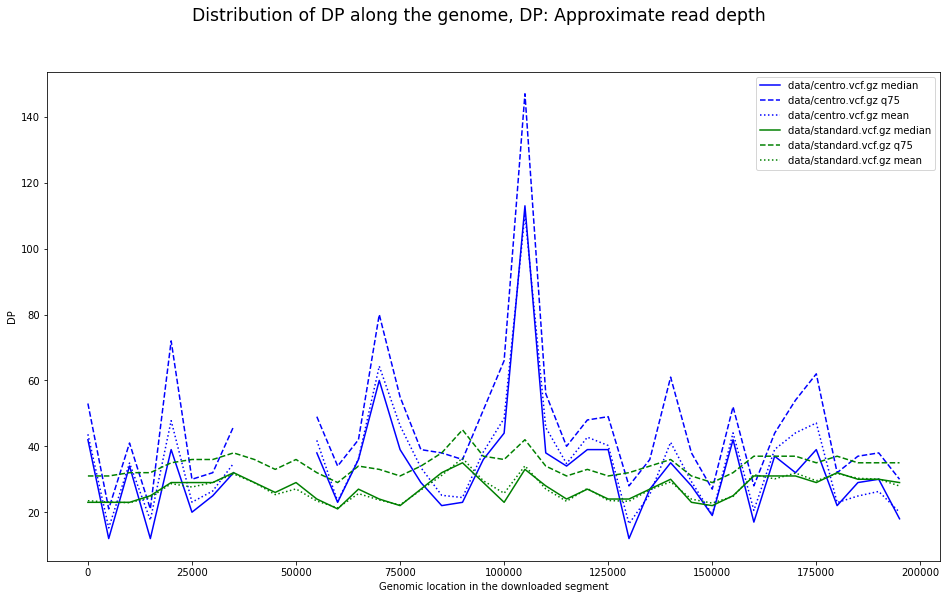

In [19]:
dp_wins = {}
size = 5000

for name in names:
    recs = vcf.Reader(filename=name)
    dp_wins[name] = do_window(recs, size, functools.partial(get_sample, annot='DP', my_type=int))

stats = {}
colors = ['b', 'g']
i = 0
fig, ax = plt.subplots(figsize=(16, 9))
for name, nwins in dp_wins.items():
    stats[name] = apply_win_funs(nwins, {'median': np.median, '75': functools.partial(np.percentile, q=75), 'mean': np.mean})
    x_lim = [j * size  for j in range(len(stats[name]))]
    ax.plot(x_lim, [x['median'] for x in stats[name]], label=name+" median", color=colors[i])
    ax.plot(x_lim, [x['75'] for x in stats[name]], '--', label=name+" q75", color=colors[i])
    ax.plot(x_lim, [x['mean'] for x in stats[name]], ':', label=name+" mean", color=colors[i])
    i += 1
#ax.set_ylim(0, 150)
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('DP')
fig.suptitle('Distribution of DP along the genome, DP: Approximate read depth', fontsize='xx-large')

### Function get_sample_relation

In this function, for every record that is iterated through, all sample information are traversed. On that level, two configurable functions are used on every sample and stored in a variable which are then used to count all SNPs with that particular characteristic-combination.

First entries in the defaultdic:<br>
```python
print(rels[name]) -> defaultdict(<class 'int'>, {(0, 11): 10418, (0, 22): 11914, (0, 34): 16412, (0, 29): 15162, ..
```
This means, that the algorithm found the first characteristic "not-heterozygous" (Hence: 0) and a read depth of 11. It is stored as key and all following similar combinations are counted as +1 for a value to that specific key.

In [20]:
def get_sample_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        for sample in rec.samples:
            try:
                v1 = f1(sample)
                v2 = f2(sample)
                if v1 is None or v2 is None:
                    continue  # We ignore Nones
                rel[(v1, v2)] += 1
                #careful with the size, floats: round?
            except:
                # This is outside the domain (typically None)
                pass
    return rel

In [21]:
rels = {}
for name in names:
    recs = vcf.Reader(filename=name)
    rels[name] = get_sample_relation(recs, lambda s: 1 if s.is_het else 0, lambda s: int(s['DP']))

### Function plot_hz_rel

The function takes the ordered list of every read depth, axis, the name of the files, and the dictionaries rels with the information about heterogenity-read depth combination related to all SNPs with that specific characteristic.
Through the sorted list of read depth is traversed and for every read depth, all keys in rel are iterated through. Only when the read depth matches the read depth of a key in rel, the corresponding value is added to a variable cnt with the former value of 0. This can happen two times at most, since the read depth can match one time for non-heterozygous and for heterozygous (0 and 1). 
Therefore, every position for every sample with a specific read depth (heterozygous or not) is counted in the variable cnt. On the contrary, every position for every sample with a specific read depth which is heterozygous (and therefore a mutation) is counted in the variable hz.
The variable cnt which stands now for number of positions per read depth is plotted with a stashed line, while the fraction of all heterzygous and all positions with a specific read depth (hz / cnt) is plotted with a continuous line.

In [22]:
def plot_hz_rel(dps, ax, ax2, name, rel):
    frac_hz = []
    cnt_dp = []
    for dp in dps:
        hz = 0.0
        cnt = 0

        for khz, kdp in rel.keys():
            if kdp != dp:
                continue
            cnt += rel[(khz, dp)]
            if khz == 1:
                hz += rel[(khz, dp)]
        frac_hz.append(hz / cnt)
        cnt_dp.append(cnt)
    ax.plot(dps, frac_hz, label=name+" fraction")
    ax2.plot(dps, cnt_dp, '--', label=name+" quantity")

#### Example for read depth 30
The counter (cnt) corresponding to the property combination heteryzygous genotype - read depth 30 and homozygous genotype - read depth is shown. From those two values, the fraction and the quantity is calculated, which is then shown in the following diagram for every read depth.

In [23]:
for name in names:
    print(name)
    print("homozygous",rels[name][(0,30)])
    print("heterozygous",rels[name][(1,30)])
    print("fraction",rels[name][(1,30)]/rels[name][(0,30)])
    print("sum(quantity)",rels[name][(1,30)]+rels[name][(0,30)],"\n")

data/centro.vcf.gz
homozygous 15818
heterozygous 1535
fraction 0.09704134530281958
sum(quantity) 17353 

data/standard.vcf.gz
homozygous 161616
heterozygous 18637
fraction 0.11531655281655281
sum(quantity) 180253 



Text(0.5, 0.98, 'Number of calls per depth and fraction of calls which are Hz')

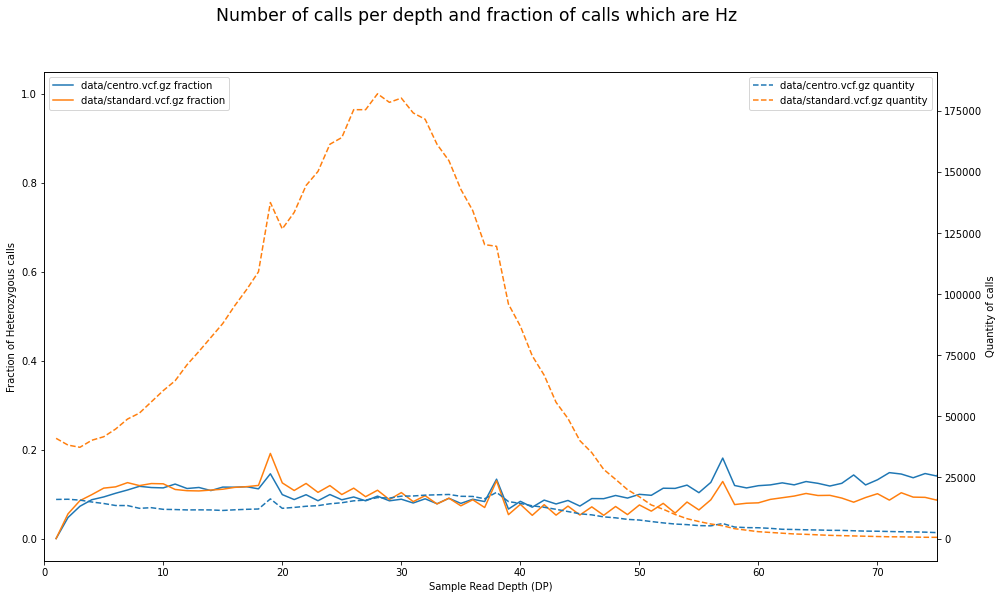

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()
for name, rel in rels.items():
    dps = list(set([x[1] for x in rel.keys()]))
    dps.sort()
    plot_hz_rel(dps, ax, ax2, name, rel)
ax.set_xlim(0, 75)
#ax.set_ylim(0, 1)
ax2.set_ylabel('Quantity of calls')
ax.set_ylabel('Fraction of Heterozygous calls')
ax.set_xlabel('Sample Read Depth (DP)')
ax.legend(loc=2)
ax2.legend(loc=1)
fig.suptitle('Number of calls per depth and fraction of calls which are Hz',fontsize='xx-large')

### Function get_variant_relation

Like in the function before, this function iterates through all records. The difference is, that variant relations do not need an extra for-loop to reach a deeper level. Therefore, the needed information are all gathered on the record level. The following procedure is the same as in the function before: two configurable functions are given and applied to the record. The result from both functions are stored in a tuple and used as key in a defaultdic. With that every following similar key increases the value count to the corresponding key.

The functions which are applied here, are for once a function "eff_to_int" where the information about the predicted effect of this variant is stored in a list according to 4 different characteristics defined in accepted_eff. The second function given is one that retrieves the variant specific read depth.

In [25]:
def get_variant_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
             continue
        try:
            v1 = f1(rec)
            v2 = f2(rec)
            if v1 is None or v2 is None:
                continue  # We ignore Nones
            rel[(v1, v2)] += 1
            #careful with the size, floats: round?
        except:
            # This is outside the domain (typically None)
            pass
    return rel

### Function eff_to_int

The function takes the vcf file information on sample level and splits the first word of the outcome of INFO['EFF'] and returns it. That word which is targeted here contains information on the annotation (or effect) of the specific allele. Therefore, the information in that specific position relates to the kind of variant which was found in the sample (e.g. Intergenic, Non-Synonymous or protein sequence alternating etc.) 

In [26]:
accepted_eff = ['INTERGENIC', 'INTRON', 'NON_SYNONYMOUS_CODING', 'SYNONYMOUS_CODING']

def eff_to_int(rec):
    try:
        for annot in rec.INFO['EFF']:
            #We use the first annotation
            master_type = annot.split('(')[0]
            return accepted_eff.index(master_type)
    except ValueError:
        return len(accepted_eff)

In [27]:
eff_mq0s = {}
for name in names:
    recs = vcf.Reader(filename=name)
    eff_mq0s[name] = get_variant_relation(recs, lambda r: eff_to_int(r), lambda r: int(r.INFO['DP']))

### Applying get_variant_relation

In the created dictionaries the information about the category of the predicted effect of the variant with the variant read depth as key corresponding to the counter of variants which match exactly these characteristics are stored. To process this information on a boxplot, a list with four empty lists as entries is created. From here on, the values are ordered per category in one of the lists. Additionally, the variant read depth are stored as often as the values number.

Example:
The first key-value pair of one eff_mq0s is (0, 1487): 4. That means, the variant with the category Intergenic (corresponds to the 0) with a read depth of 1487 appears 4 times in all records. This key-value pair gets stripped of and is stored in the first of the four lists in bp_vals because it goes in the first category. In there, the read depth is stored 4 times. Therefore, the beginning of bp_vals looks like this: 
>[[1487, 1487, 1487, 1487...

Hence, all variant read depth are saved seperatly to their category. This can be plotted using the seaborn boxplot function.

Text(0.5, 0.98, 'Distribution of variant DP per SNP type')

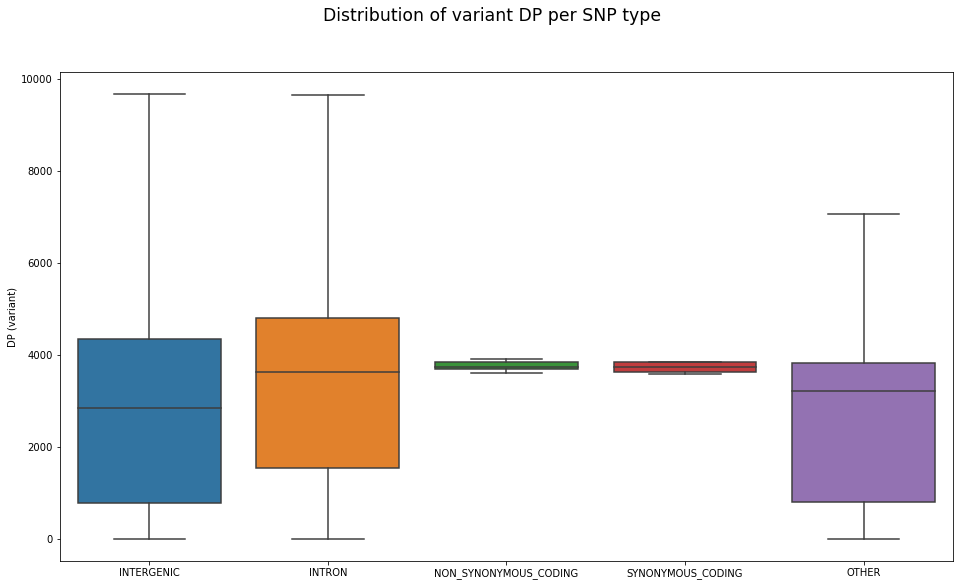

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
bp_vals = [[] for x in range(len(accepted_eff) + 1)]
for k, cnt in eff_mq0s[names[0]].items():
    my_eff, mq0 = k
    bp_vals[my_eff].extend([mq0] * cnt)
sns.boxplot(data=bp_vals, sym='', ax=ax)
ax.set_xticklabels(accepted_eff + ['OTHER'])
ax.set_ylabel('DP (variant)')
fig.suptitle('Distribution of variant DP per SNP type',fontsize='xx-large')

### Applying relations-function to create heat maps

As described before, one of the relation functions is used to count the combination of two properties over all data. For each call, a dictionary is passed with the property combinations as key and the respective counters as value.
The keys are iterated through to identify the smallest and largest value for each property (=4 values). These values are used to create a matrix with the total range of the first property (max0 - min0 +1) as the number of lists in the list (or number of rows) and the total range of the second property as the number of zeros per list (or number of columns). 
Then the dictionary is iterated through and for the position in the matrix with the respective property combination the respective counter for the 0 is inserted at this position.
Each 0 can be changed at most once, because the key-value combinations in the dictionary are unique.

In [29]:
recs = vcf.Reader(filename=names[1])
#mq0_dp = get_sample_relation(recs, lambda r: int(r['DP']), lambda r: int(r['GQ']))
mq0_dp = get_variant_relation(recs, lambda r: int(r.INFO['DP']) // 10, lambda r: int(float(r.INFO['MQ'])* 10))

In [30]:
maxv0 = 0
maxv1 = 0
minv0 = float('inf')
minv1 = float('inf')
for v0, v1 in mq0_dp.keys():
    if v0 > maxv0:
        maxv0 = v0
    if v1 > maxv1:
        maxv1 = v1
    if v0 < minv0:
        minv0 = v0
    if v1 < minv1:
        minv1 = v1
print(minv0, minv1, maxv0, maxv1)
#minv1 = 300
#maxv1 = 600
#maxv0 = 400
mat = np.zeros((maxv0 - minv0 + 1, maxv1 - minv1 + 1), dtype=int)
for k, cnt in mq0_dp.items():
    v0, v1 = k
    #if v0 > maxv0:
    #    continue
    #if v1 < minv1 or v1 > maxv1:
    #    continue
    mat[v0 - minv0, v1 - minv1] = cnt

0 7 688 589


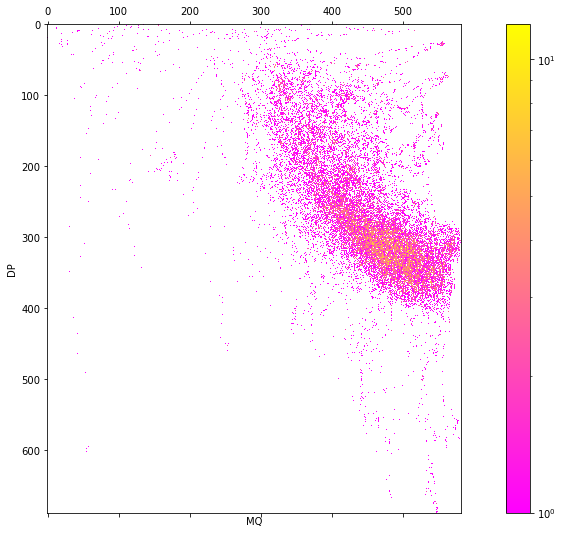

In [31]:
from matplotlib import colors
fig, ax = plt.subplots(figsize=(16,9))
mtax = ax.matshow(mat, norm=colors.LogNorm(), cmap=plt.get_cmap('spring'))
ax.set_xlabel('MQ')
ax.set_ylabel('DP')
cbar = fig.colorbar(mtax, orientation='vertical')

Important sources: <br>
    https://www.youtube.com/watch?v=EpD2ZHM7Q8Q&t=186s&ab_channel=IGV Introduction about vcf files <br>
    https://hub.packtpub.com/processing-next-generation-sequencing-datasets-using-python/ Main article <br>
    https://buildmedia.readthedocs.org/media/pdf/pyvcf/latest/pyvcf.pdf documentation of pyvcf reader <br>
    https://pyvcf.readthedocs.io/en/latest/API.html more documentation about the pyvcf reader <br>
    http://samtools.github.io/hts-specs/VCFv4.1.pdf documentation about vcf files and its key-value specifications <br>
    https://gatk.broadinstitute.org/hc/en-us/articles/360035531692-VCF-Variant-Call-Format more documentation about vcf files (nice beginners guide)<br>
    https://matplotlib.org/stable/index.html Matplotlib documentation <br>

### For the ipynb used conda environment yaml file to recreate

To create an conda environment from following cell, copy the text in a .yml file (i.e. ngspy.yml), change the prefix to the corresponding local path and create the conda environment from this using:<br>
conda env create -f ngspy.yml<br>
(see: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file)